# Bosonic Squeezing

Photonic squeezing, or more generally bosonic squeezing, refers to the manipulation of the uncertainties of orthogonal quadratures such that one of the values exists below the standard quantum limit. For a coherent state, the values of the quadratures $\hat{X}$ and $\hat{P}$ are equal, and are minimized according to the Heisenberg uncertainty principle: $$ \Delta X \Delta P \geq \frac{1}{2} $$

This reduced uncertainty in one of the quadratures allows for much better precision in applications such as quantum metrology and gravitational wave detectors.

The quadratures $X$ and $P$ are defined with respect to the bosonic creation / annihilation as:

$$ \hat{X} = a^{\dagger} + a \qquad \hat{P} = \frac{a^{\dagger} - a}{i} $$ 

Squeezing is generated by a nonlinear Hamiltonian in the bosonic creation and annihilation operators:
$$ H = i(\kappa a^{\dagger 2} - \kappa^* a^2) $$

Here, $\kappa$ sets the squeezing strength, and $a$ is the bosonic annihilation operator. 

When acting on the vacuum $\lvert 0 \rangle$, we get a squeezed vacuum state with a photon number $n = \langle a^{\dagger}a \rangle > 0$.

## Code Implementation

1. The Hamiltonian `H` is created from the creation and annihilation operators as defined above.

2. We use the `wigner` function from qutip in order to visualize the state in quadrature space.

3. The photon number $\langle n \rangle$ is plotted as a function of time and compared to the theoretical value $$ n = \sinh^2(2\chi t) $$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import operator
import math
import functools
import itertools

from qutip import *
from oqd_core.interface.analog.operator import *
from oqd_core.interface.analog.operation import *
from oqd_core.backend.metric import *
from oqd_core.backend.task import Task, TaskArgsAnalog
from oqd_analog_emulator.qutip_backend import QutipBackend

import warnings
warnings.filterwarnings("ignore")

In [3]:
chi = 0.01
N = 100
a = Annihilation()
adag = Creation()
H = 1j * (chi * adag * adag - np.conj(chi) * a * a)

circuit = AnalogCircuit()
circuit.evolve(duration=25, gate=AnalogGate(hamiltonian= H))

args = TaskArgsAnalog(
    fock_cutoff=N,
    metrics={
        "n": Expectation(operator= adag * a),
    },
    dt=5e-4,
)

task = Task(program=circuit, args=args)

backend = QutipBackend()
results = backend.run(task=task)

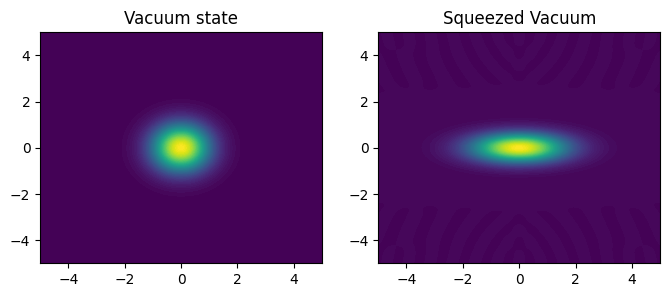

In [4]:
xvec = np.linspace(-5,5,200)

rho_coherent = coherent_dm(N, 0)
W_coherent = wigner(rho_coherent, xvec, xvec)

a = results.state
a_nat = [complex(c.real, c.imag) for c in a]
state_arr = np.array(a_nat, dtype=np.complex128)
qt_state = qutip.Qobj(state_arr, dims=[[N], [1]])
W_squeeze = wigner(qt_state, xvec, xvec)

fig, axes = plt.subplots(1, 2, figsize=(8,3))
cont0 = axes[0].contourf(xvec, xvec, W_coherent, 100)
lbl0 = axes[0].set_title("Vacuum state")
cont0 = axes[1].contourf(xvec, xvec, W_squeeze, 100)
lbl0 = axes[1].set_title("Squeezed Vacuum")
plt.show()

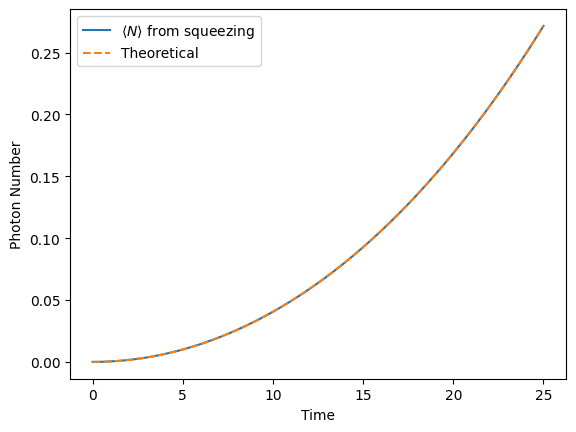

In [5]:
n = np.array(results.metrics["n"])
plt.plot(results.times, n, label=f"$\\langle N \\rangle$ from squeezing")

theory_n = np.sinh(2 * chi * np.array(results.times)) ** 2
plt.plot(results.times, theory_n, label="Theoretical", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Photon Number")
plt.legend()